In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
import shap

data = pd.read_csv('final_cleaned_dummy_data.csv').drop(columns=['Unnamed: 0', 'index'])
data_li = pd.read_csv('lowIncomeFilteredData.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

Creating Dummy Variables in Low Income Data, Dropping Burden Outliers, Instantiating MSE List

In [54]:
# use one hot encoding to convert categorical variables into series of binary variables
non_binary_cat_vars = ['ACPRIMARY','BLD','COOKFUEL','DIVISION','HEATFUEL',\
                       'HEATTYPE','HHRACE','HOTWATER','TENURE']

cat_df = data_li[non_binary_cat_vars].copy(deep=True)

enc = OneHotEncoder()
enc.fit(cat_df)
onehotlabels = enc.transform(cat_df).toarray()
one_hot_df = pd.DataFrame(onehotlabels, columns=enc.get_feature_names_out())

# recombine dataframes
final_data_li = pd.concat([one_hot_df,data_li.drop(columns=non_binary_cat_vars)], axis=1)

data.drop(data.loc[data['HINCP']==0].index, inplace=True)

data.drop(data.loc[data['BURDEN']>1.3068144].index, inplace=True)
data.drop(data.loc[data['BURDEN']<=0].index, inplace=True)
#data.drop(data.loc[data['BURDEN']<=0.0070588235].index, inplace=True) #5th percentile

final_data_li.drop(final_data_li.loc[final_data_li['BURDEN']>1.3068144].index, inplace=True)
final_data_li.drop(final_data_li.loc[final_data_li['BURDEN']<=0].index, inplace=True)

final_data_li.drop(final_data_li.loc[final_data_li['HINCP']==0].index, inplace=True)

mses = [[0,0] for i in range(6)]

Run only one of the six cells below, depending on desired model configuration

Random Forest 1: Both Urban and Rural, All Income

In [55]:
# select features, set target, split test set
features_all = data.drop(columns=['HINCP','OTHERAMT','GASAMT','OILAMT',\
                                  'ELECAMT','NUMPEOPLE','METRO','BURDEN'])
target = data['BURDEN']
X, X_test, y, y_test = train_test_split(features_all, target, random_state = 1, test_size = .2)
config = 1

Random Forest 2: Urban, All Income

In [3]:
# select features, set target, split test set
features_all_urban = data[data.URBAN==1].drop(columns=['HINCP','OTHERAMT','GASAMT','OILAMT','ELECAMT',\
                                                       'NUMPEOPLE','METRO','BURDEN','URBAN'])
target = data[data.URBAN==1]['BURDEN']
X, X_test, y, y_test = train_test_split(features_all_urban, target, random_state = 1, test_size = .2)
config = 2

Random Forest 3: Rural, All Income

In [12]:
# select features, set target, split test set
features_all_rural = data[data.URBAN==0].drop(columns=['HINCP','OTHERAMT','GASAMT','OILAMT','ELECAMT',\
                                                       'NUMPEOPLE','METRO','BURDEN','URBAN'])
target = data[data.URBAN==0]['BURDEN']
X, X_test, y, y_test = train_test_split(features_all_rural, target, random_state = 1, test_size = .2)
config = 3

Random Forest 4: Both Urban and Rural, Low Income

In [24]:
# select features, set target, split test set
features_all_li = final_data_li.drop(columns=['HINCP','OTHERAMT','GASAMT','OILAMT','ELECAMT','NUMPEOPLE',\
                                              'METRO','BURDEN','HHAGE','NUMKIDS', 'POVTHRESH', 'LITHRESH'])
target = final_data_li['BURDEN']
X, X_test, y, y_test = train_test_split(features_all_li, target, random_state = 1, test_size = .2)
config = 4

Random Forest 5: Urban, Low Income

In [34]:
# select features, set target, split test set
features_all_urban_li = final_data_li[final_data_li.URBAN==1]\
                        .drop(columns=['HINCP','OTHERAMT','GASAMT','OILAMT','ELECAMT','NUMPEOPLE',\
                                       'METRO','BURDEN','HHAGE','NUMKIDS', 'POVTHRESH', 'LITHRESH','URBAN'])
target = final_data_li[final_data_li.URBAN==1]['BURDEN']
X, X_test, y, y_test = train_test_split(features_all_urban_li, target, random_state = 1, test_size = .2)
config = 5

Random Forest 6: Rural, Low Income

In [44]:
# select features, set target, split test set
features_all_rural_li = final_data_li[final_data_li.URBAN==0]\
                        .drop(columns=['HINCP','OTHERAMT','GASAMT','OILAMT','ELECAMT','NUMPEOPLE',\
                                       'METRO','BURDEN','HHAGE','NUMKIDS', 'POVTHRESH', 'LITHRESH','URBAN'])
target = final_data_li[final_data_li.URBAN==0]['BURDEN']
X, X_test, y, y_test = train_test_split(features_all_rural_li, target, random_state = 1, test_size = .2)
config = 6

After running one of the six cells above to choose features and output, continue below.

In [56]:
# split between train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 1, test_size = 0.2)

# instantiate random forest regressor
rf_tree = RandomForestRegressor()
rf_tree.fit(X_train, y_train)

# set parameter distribution for random search CV

# param_dist_rf = {'n_estimators': randint(10, 100),
#               'max_leaf_nodes': randint(3, 100),
#               'max_features': ["auto"],
#               'max_depth': randint(1, 10),
#               'min_samples_leaf': randint(1, 30),
#               'min_samples_split': randint(2, 20)}
param_dist_rf = {'n_estimators': randint(1, 2500),
              'max_leaf_nodes': randint(3, 200),
              'max_features': ["auto"],
              'max_depth': randint(1, 50),
              'min_samples_leaf': randint(1, 40),
              'min_samples_split': randint(2, 40)}

The following cell will take the longest to run. If it takes too long, alter params above or n_iter keyword in the RandomizedSearchCV() call.

In [57]:
rnd_search_rf = RandomizedSearchCV(rf_tree, param_distributions=param_dist_rf, cv=10, n_iter=1)
# default n_iter = 200 for data lab

rnd_search_rf.fit(X_train, y_train)

print(rnd_search_rf.best_params_)

# fit tree with best parameters
rf_tree.set_params(max_leaf_nodes=rnd_search_rf.best_params_['max_leaf_nodes'], 
                    n_estimators=rnd_search_rf.best_params_['n_estimators'], 
                    max_features = rnd_search_rf.best_params_['max_features'],
                    max_depth = rnd_search_rf.best_params_['max_depth'],
                    min_samples_leaf = rnd_search_rf.best_params_['min_samples_leaf'],
                    min_samples_split = rnd_search_rf.best_params_['min_samples_split'])

# These scores carry no meaning for the random forest regressor, but will still print out
rf_train_score = rf_tree.score(X_train, y_train)
rf_val_score = rf_tree.score(X_val, y_val)
print('Train Score: ', rf_train_score)
print('Validation Score: ', rf_val_score)

{'max_depth': 42, 'max_features': 'auto', 'max_leaf_nodes': 174, 'min_samples_leaf': 19, 'min_samples_split': 8, 'n_estimators': 2497}
Train Score:  0.7926975962119489
Validation Score:  -0.14788282797632601


Built-In Feature Importance

In [58]:
importances = rf_tree.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_tree.estimators_],
              axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

feat_imp = []
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f, X.columns[indices[f]], importances[indices[f]]))
    feat_imp.append((X.columns[indices[f]], importances[indices[f]]))
    
feat_df = pd.DataFrame(feat_imp, columns=['Feature','Importance'])
feat_df.set_index('Feature',inplace=True)
feat_df.to_csv('rf_out/feat_importance/built_in_importances_{}.csv'.format(str(config)))
feat_df = feat_df.T

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.savefig('rf_out/figs/feat_imp/built_in_feature_importance_{}.png'.format(str(config)),dpi=300)
plt.clf()

Feature ranking:
0. YRBUILT (0.160470)
1. UNITSIZE (0.096357)
2. NUMELDERS (0.040533)
3. FIREPLACE (0.031630)
4. NUMOLDKIDS (0.028411)
5. COOKFUEL_2 (0.023036)
6. HEATTYPE_1 (0.021207)
7. DIVISION_5 (0.021032)
8. COOKFUEL_1 (0.021002)
9. DIVISION_7 (0.019653)
10. HOTWATER_1 (0.019357)
11. ACPRIMARY_1 (0.018790)
12. DIVISION_8 (0.018774)
13. HOTWATER_2 (0.018720)
14. HEATFUEL_2 (0.018540)
15. NUMYNGKIDS (0.017110)
16. HEATFUEL_1 (0.016974)
17. BLD_6 (0.016535)
18. URBAN (0.016386)
19. DIVISION_3 (0.016379)
20. HHRACE_2.0 (0.016149)
21. HEATTYPE_3 (0.015763)
22. BLD_7 (0.015330)
23. TENURE_1.0 (0.015180)
24. DIVISION_9 (0.014407)
25. BLD_2 (0.013331)
26. ACPRIMARY_0 (0.012960)
27. HEATTYPE_5 (0.012771)
28. ACPRIMARY_4 (0.012629)
29. BLD_1 (0.011045)
30. DIVISION_2 (0.010726)
31. HEATTYPE_2 (0.010169)
32. HHRACE_1.0 (0.010033)
33. BLD_3 (0.010006)
34. BLD_5 (0.009652)
35. BLD_9 (0.009593)
36. DIVISION_6 (0.009516)
37. TENURE_2.0 (0.009140)
38. DIVISION_1 (0.009135)
39. BLD_8 (0.009054)
40

<Figure size 640x480 with 0 Axes>

Residuals

In [59]:
resid_df = pd.DataFrame(y-rf_tree.predict(X))
resid_df.to_csv('rf_out/residuals/residuals_{}.csv'.format(str(config)))
plt.scatter(np.arange(len(y)),y-rf_tree.predict(X))
plt.savefig('rf_out/residuals/figs/residuals_{}.png'.format(str(config)),dpi=300)
plt.clf()
plt.scatter(np.arange(len(y)),np.sort(y-rf_tree.predict(X)))
plt.savefig('rf_out/residuals/figs/residuals_sorted_{}.png'.format(str(config)),dpi=300)
plt.clf()

<Figure size 640x480 with 0 Axes>

Permutation Importance (may take a long time to run)

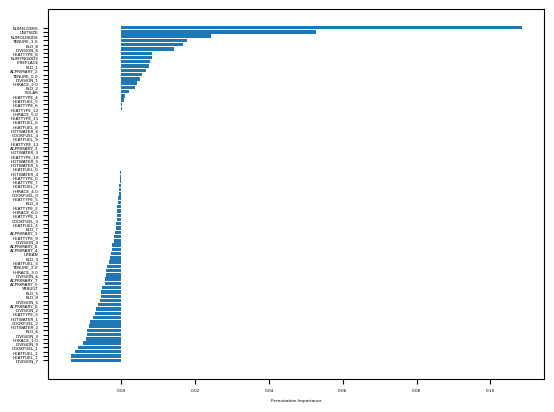

In [60]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['font.size'] = 3
perm_importance = permutation_importance(rf_tree, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
perm_df = pd.DataFrame(perm_importance.importances_mean[sorted_idx],\
                       index=X.columns[sorted_idx],columns=['Importance'])
perm_df.sort_values(by='Importance',ascending=False).to_csv('rf_out/feat_importance/permutation_importance_{}.csv'.format(str(config)))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.savefig('rf_out/figs/feat_imp/permutation_importance/permutation_importance_{}.png'\
                .format(str(config)),dpi=300)
plt.rcParams.update(plt.rcParamsDefault)

Shapley Values (may take a long time to run)

In [ ]:
explainer = shap.TreeExplainer(rf_tree)
shap_values = explainer.shap_values(X_test)
shap_abs = np.abs(shap_values)
shap_df = pd.DataFrame(shap_abs.mean(axis=0),columns=['Shapley Value'])
shap_df['Feature'] = X.columns[shap_df.index]
shap_df.sort_values(by='Shapley Value',ascending=False, inplace=True)
shap_df = shap_df.reset_index().drop(columns=['index']).set_index(shap_df.Feature).drop(columns=['Feature'])
shap_df.to_csv('rf_out/feat_importance/shapley_{}.csv'.format(str(config)))
shap.summary_plot(shap_values, X_test, plot_type="bar",show=False)
plt.savefig('rf_out/figs/feat_imp/shapley/shapley_bar_{}.png'\
                .format(str(config)),dpi=300, bbox_inches='tight')
plt.clf()
shap.summary_plot(shap_values, X_test,show=False)
plt.savefig('rf_out/figs/feat_imp/shapley/shapley_jitter_{}.png'\
                .format(str(config)),dpi=300, bbox_inches='tight')

# max_display keyword in summary_plot call changes # of features shown on plot

Mean Squared Error (after running this cell, go back and rerun a new configuration until all 6 are run)

In [61]:
mse_test = mean_squared_error(y_test,rf_tree.predict(X_test))
mse_val = mean_squared_error(y_val,rf_tree.predict(X_val))
print('Test MSE is:',mse_test)
print('Val MSE is:',mse_val)

mses[config-1][0] = mse_test
mses[config-1][1] = mse_val

Test MSE is: 0.014105814283013923
Val MSE is: 0.015534764545131332


In [ ]:
# When all 6 configurations are finished, run this cell to output the MSEs
mse_df = pd.DataFrame(mses, index=['Config 1','Config 2','Config 3','Config 4','Config 5','Config 6'],\
                     columns=['Test MSE','Val MSE'])
mse_df.to_csv('rf_out/mses.csv')

In [51]:
mses

[[0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0.034943014273540136, 0.03555582529570137]]